# ATMO 5331 - Homework 2 - Fall 2021
## Due 16 Sep, 2021

When doing this homework, remember that you have two jobs:
1. Make it work.
2. Clean it up so that I can understand what you've done. If you think I might not undersand, document it with a comment or a function docstring.

You should present your work with a clear logical progression. If that seems like a hassle, remember that in doing so you are practicing skills that are expected in your thesis and journal publications.

You may work alone or in pairs. I will not be adjudicating relative level of effort in group work, so you are responsible for ensuring there is an even contribution by your partner.

**Question 1**

Grab the [WGS84 implementation manual](https://www.icao.int/safety/pbn/documentation/eurocontrol/eurocontrol%20wgs%2084%20implementation%20manual.pdf), and implement a translation from geodetic latitude, longitude, and altitude (referenced to the WGS84 ellisoid) to the local XYZ cartesian system used for WGS84.

Use part 1 of Helmert's formula on p. 81 (Appendix E), and refer to Fig. B-6 in Appendix B (p. 70) for information about the coordinate system notation.

Careful with degrees and radians.

Compare your results to what you get when using the `proj4` library. This library has its origins in public domain code written by the USGS, and is used in many open source packages, including the QGIS system. For easy use of the `proj4` library, you can use the [helper routines in coordinateSystems.py](https://github.com/deeplycloudy/lmatools/blob/minvaluegrids/lmatools/coordinateSystems.py) from my `lmatools` package. Just copy that file into the same directory as this notebook.

You set up a coordinate system transform object as shown below. It defaults to a WGS84 ellipsoid, so we don't have to specify that. Once the coordinate system object `geo` has been created, you can reuse it withouth calling `GeographicSystem()` again. It accepts arrays of data.
```
from coordinateSystems import GeographicSystem 
geo = GeographicSystem() 
X, Y, Z = geo.toECEF(lon, lat, alt) # Use degrees
```

For your dataset, please use: 
```
import numpy as np
lat = np.array([  33.5,   1.0,   0.0,   0.0,   0.0,  10.0, -10.0]) 
lon = np.array([-101.5, -75.0, -85.0, -65.0, -75.0, -75.0, -75.0]) 
alt = np.zeros_like(lat)
```

Demonstrate that your ECEF conversion equals that provided by the coordinate system library.


In [129]:
import numpy as np
lat = np.array([  33.5,   1.0,   0.0,   0.0,   0.0,  10.0, -10.0]) 
lon = np.array([-101.5, -75.0, -85.0, -65.0, -75.0, -75.0, -75.0]) 
alt = np.zeros_like(lat)

# converting degrees to radians
lat_in_rad = lat*(np.pi/180)
lon_in_rad = lon*(np.pi/180)

# identifying constants and equations used for the conversion
a = 6378137
f = 1/298.257223563
esq = (f*(2-f))
v = a/(1-esq*(np.sin(lat_in_rad)**2))**(.5)

# converting coords to ECEP using the following equations
X1 = (v+alt)*(np.cos(lat_in_rad))*(np.cos(lon_in_rad))
Y1 = (v+alt)*(np.cos(lat_in_rad))*(np.sin(lon_in_rad))
Z1 = (v*(1-esq)+alt)*np.sin(lat_in_rad)

print(X1,Y1,Z1)

# comparing my calculated values to the library values
from coordinateSystems import GeographicSystem 
geo = GeographicSystem() 
X, Y, Z = geo.toECEF(lon, lat, alt) # Use degrees

print(X,Y,Z)

[-1061448.75418035  1650533.58831094   555891.26758132  2695517.17208404
  1650783.32787306  1625868.32721344  1625868.32721344] [-5217187.30723133 -6159875.21117539 -6353866.26310279 -5780555.22988658
 -6160807.25190988 -6067823.20357756 -6067823.20357756] [ 3500334.28802236   110568.77482457        0.                0.
        0.          1100248.54773536 -1100248.54773536]
[-1061448.75418035  1650533.58831094   555891.26758132  2695517.17208404
  1650783.32787306  1625868.32721344  1625868.32721344] [-5217187.30723133 -6159875.21117539 -6353866.26310279 -5780555.22988658
 -6160807.25190988 -6067823.20357756 -6067823.20357756] [ 3500334.28802236   110568.77482457        0.                0.
        0.          1100248.54773536 -1100248.54773536]


**Question 2.**

Using the `TangentPlaneCartesianSystem` class, convert the geodetic coordinates to local $(x, y, z)$. Create three tangent planes:

- A tangent plane centered at the MCOM building on the TTU campus, at the height of the ground at that location.

- A tangent plane centered at the MCOM building on the TTU campus, at the ellipsoid.

- A tangent plane directly below the GOES-East satellite at -75.0 degrees longitude.

Use `TangentPlaneCartesianSystem?` in the notebook to learn about the arguments accepted by the projection class. It has the same `.toECEF` and `.fromECEF` methods as the `GeographicSystem`.

Transform the geodetic dataset from the first problem into coordiantes with respect to each tangent plane.

You do not need to use the NAD83 locations of MCOM. They are only there to show my work on how I obtained the vertical position of MCOM in WGS84.

**a.** Using only the GOES-East tangent plane and the transformed geodetic dataset, show that the WGS84 earth shape is not spherical.

**b.** What is a rough, easily memorable rule of thumb for the number of kilometers per degree latitude?

**c.** Print out the tangent plane $(x,y,z)$ of the zeroth data point (it is a bit east of Lubbock). Explain why the differences in the coordinates of the two MCOM tangent planes make sense.

**d.** Imagine that there was no terrain, so that a radar located at MCOM was precisely on the WGS84 ellipsoid. If that radar were to scan toward the zeroth position at 0° elevation angle (assume no atmospheric refraction), how high above the ground would the beam be? Is this disance measured perpendicular to the ellipsoid or perpendicular to the tangent plane?

**e.** Transform your coordiantes back to ECEF from each tangent plane and show they're equal.

In [130]:
from coordinateSystems import TangentPlaneCartesianSystem

# From USGS Elevation point query service
# https://nationalmap.gov/epqs/
# NAD83 lon, lat and NAVD88 vertical
mcom_lat_nad83, mcom_lon_nad83 = 33.581857, -101.880360 # NAD83
mcom_alt_nad83 = 983.15

# Using https://vdatum.noaa.gov/vdatumweb/, convert the above to "WGS84 G1674 (Use ITRF2008)"
mcom_lon, mcom_lat = -101.8803718553, 33.5818617015
mcom_alt = 957.179

# The altitude difference is about the height of the geoid at this location.

In [131]:
# before I do anything for question 2, I have created our three tangents
mcom1 = TangentPlaneCartesianSystem(mcom_lat,mcom_lon, mcom_alt)
mcom2 = TangentPlaneCartesianSystem(mcom_lat,mcom_lon, mcom_alt_nad83-mcom_alt)
goes_east = TangentPlaneCartesianSystem(0, -75, 0) 

# transforming the geodetic dataset from the first problem into coordiantes with respect to each tangent plane
mcom1x, mcom1y, mcom1z = mcom1.fromECEF(X,Y,Z)
mcom2x, mcom2y, mcom2z = mcom2.fromECEF(X,Y,Z)
goes_eastx, goes_easty, goes_eastz = goes_east.fromECEF(X,Y,Z)

Explanation for a. 
In order to do this problem, I reverted back to our lat and lon coordinates. I was looking for a constant lat, but where longitude changed, and then I was also looking for two moments where longitude changed but latitude stayed constant. That way I could distinguish whether the two changes of lat and lon were equal to each other or not. If they were to be equal, then it would indicate a perfect sphere.

In [132]:
# the following is question 1.a

difference_of_lon = goes_eastx[4]-goes_eastx[3]
print(difference_of_lon)

difference_of_lat = goes_easty[5]-goes_eastx[4]
print(difference_of_lat)

# overall, if the WGS84 earth shape was spherical, the values would have been equal.

-1107551.8669600007
1100248.5477353611


1.b = about 111km per degree latitude

In [134]:
# Print out the tangent plane (𝑥,𝑦,𝑧) of the zeroth data point (it is a bit east of Lubbock). 
# Explain why the differences in the coordinates of the two MCOM tangent planes make sense.

print(mcom1x[0])
print(mcom1y[0])
print(mcom1z[0])
print(mcom2x[0])
print(mcom2y[0])
print(mcom2z[0])
print(goes_eastx[0])
print(goes_easty[0])
print(goes_eastz[0])

print(mcom2z[0])

35344.860726469895
-9014.720964740558
-1061.406735828723
35344.8607264699
-9014.720964740136
-130.19873583238768
-2375588.201968728
3500334.2879920797
-1613444.192339425
-130.19873583238768


The differences in the coordinates (only the z component or altitude) of the two MCOM tangents planes make is because the simply start at different altitudes. The first one starts at height of the ground and the second starts at the ellipsoid height. 

In [135]:
# finding the zeroth positionat 0 deg elevation angle for 2d.
print(mcom2z[0])

-130.19873583238768


2.d Imagine that there was no terrain, so that a radar located at MCOM was precisely on the WGS84 ellipsoid. If that radar were to scan toward the zeroth position at 0° elevation angle (assume no atmospheric refraction), how high above the ground would the beam be? Is this disance measured perpendicular to the ellipsoid or perpendicular to the tangent plane?

The disance measured is perpendicular to the tangent. This is because the ellipsoid is surface is curved and spherical in the case with an ellipsoid. 

In [136]:
# code from question 1 for 2.e
X1 = (v+alt)*(np.cos(lat_in_rad))*(np.cos(lon_in_rad))
Y1 = (v+alt)*(np.cos(lat_in_rad))*(np.sin(lon_in_rad))
Z1 = (v*(1-esq)+alt)*np.sin(lat_in_rad)
print(X1,Y1,Z1)

# converting coordinates back to ECEF
mcom1x1, mcom1y1, mcom1z1 = mcom1.toECEF(mcom1x, mcom1y, mcom1z)
mcom2x2, mcom2y2, mcom2z2 = mcom2.toECEF(mcom2x, mcom2y, mcom2z)
goes_eastxx, goes_eastyy, goes_eastzz = goes_east.toECEF(goes_eastx, goes_easty, goes_eastz)
print(goes_eastxx, goes_eastyy, goes_eastzz)
print(mcom2x2, mcom2y2, mcom2z2)
print(mcom1x1, mcom1y1, mcom1z1)

# As you can see, they are equal
# I belive this is what you were asking us to do, correct?

[-1061448.75418035  1650533.58831094   555891.26758132  2695517.17208404
  1650783.32787306  1625868.32721344  1625868.32721344] [-5217187.30723133 -6159875.21117539 -6353866.26310279 -5780555.22988658
 -6160807.25190988 -6067823.20357756 -6067823.20357756] [ 3500334.28802236   110568.77482457        0.                0.
        0.          1100248.54773536 -1100248.54773536]
[-1061448.75418035  1650533.58831094   555891.26758132  2695517.17208404
  1650783.32787306  1625868.32721344  1625868.32721343] [-5217187.30723134 -6159875.21117539 -6353866.26310279 -5780555.22988658
 -6160807.25190988 -6067823.20357757 -6067823.20357756] [ 3.50033429e+06  1.10568775e+05 -2.38467366e-10 -2.38467366e-10
  0.00000000e+00  1.10024855e+06 -1.10024855e+06]
[-1061448.75418035  1650533.58831094   555891.26758132  2695517.17208404
  1650783.32787306  1625868.32721344  1625868.32721344] [-5217187.30723133 -6159875.21117539 -6353866.2631028  -5780555.22988658
 -6160807.25190988 -6067823.20357757 -6067823.

**Question 3** Use the `GeostationaryFixedGridSystem` to define two more coordiante transformations for the GOES-East and GOES-West locations at -75.0 and -135.0 degrees longitude.

Use `GeostationaryFixedGridSystem?` in the notebook to learn about the arguments accepted by the projection class.

Convert the dataset to fixed grid coordinates.

For more on fixed grid coordiantes, you can read the [GOES-R L1b product users' guide](https://www.goes-r.gov/resources/docs.html) and [my own description of GOES fixed grid coordiantes](https://github.com/deeplycloudy/glmtools/blob/master/docs/fixedgridguide.md), a.k.a. [the geostationary projection](https://proj.org/operations/projections/geos.html).



In [137]:
from coordinateSystems import GeostationaryFixedGridSystem

# GOES-E and GOES-W coordinate transformtaions at -75 and -135 degrees
GOES_EAST_COORD = GeostationaryFixedGridSystem(-75.0)
GOES_WEST_COORD = GeostationaryFixedGridSystem(-135.0)
EAST_X, EAST_Y, EAST_Z = GOES_EAST_COORD.fromECEF(X,Y,Z)
WEST_X, WEST_Y, WEST_Z = GOES_WEST_COORD.fromECEF(X,Y,Z)

# printing the coords of these transformations
print(EAST_X, EAST_Y, EAST_Z)
print(WEST_X, WEST_Y, WEST_Z)

[-0.06343441  0.         -0.03085608  0.03085608  0.          0.
  0.        ] [ 0.09313517  0.00308964  0.          0.          0.          0.03065328
 -0.03065328] [ 0.00000000e+00 -2.60248972e-17 -2.60248972e-17  0.00000000e+00
 -2.60248972e-17  0.00000000e+00  0.00000000e+00]
[0.07773846 0.1407624  0.12766239 0.14879481 0.14078514 0.13851876
 0.13851876] [ 0.09224449  0.00280882  0.          0.          0.          0.02791753
 -0.02791753] [ 0.00000000e+00 -2.60248972e-17 -2.60248972e-17  0.00000000e+00
 -2.60248972e-17  0.00000000e+00  0.00000000e+00]


In [28]:
GeostationaryFixedGridSystem?

**Question 4.** Make a plot of the east and north coordinate data from the lon/lat, 3 tangent plane, and two GOES fixed grid projections, for a total of 6 plots.

Transform and plot three more locations (your hometown, your undergraduate institution's location, and the farthest you've been from home).

Does everything make sense? If not, what do you observe? Offer a plausible explanation for what might have happened.

Label the coordinates with the altitude of the point in that coordinate reference system.

[326578.63268671 260482.4179252  711865.9061374 ] [-4760794.57633124 -4855493.77058888 -6147778.34116824] [4218028.86191609 4114034.94933094 1537181.88557462]


<IPython.core.display.Javascript object>


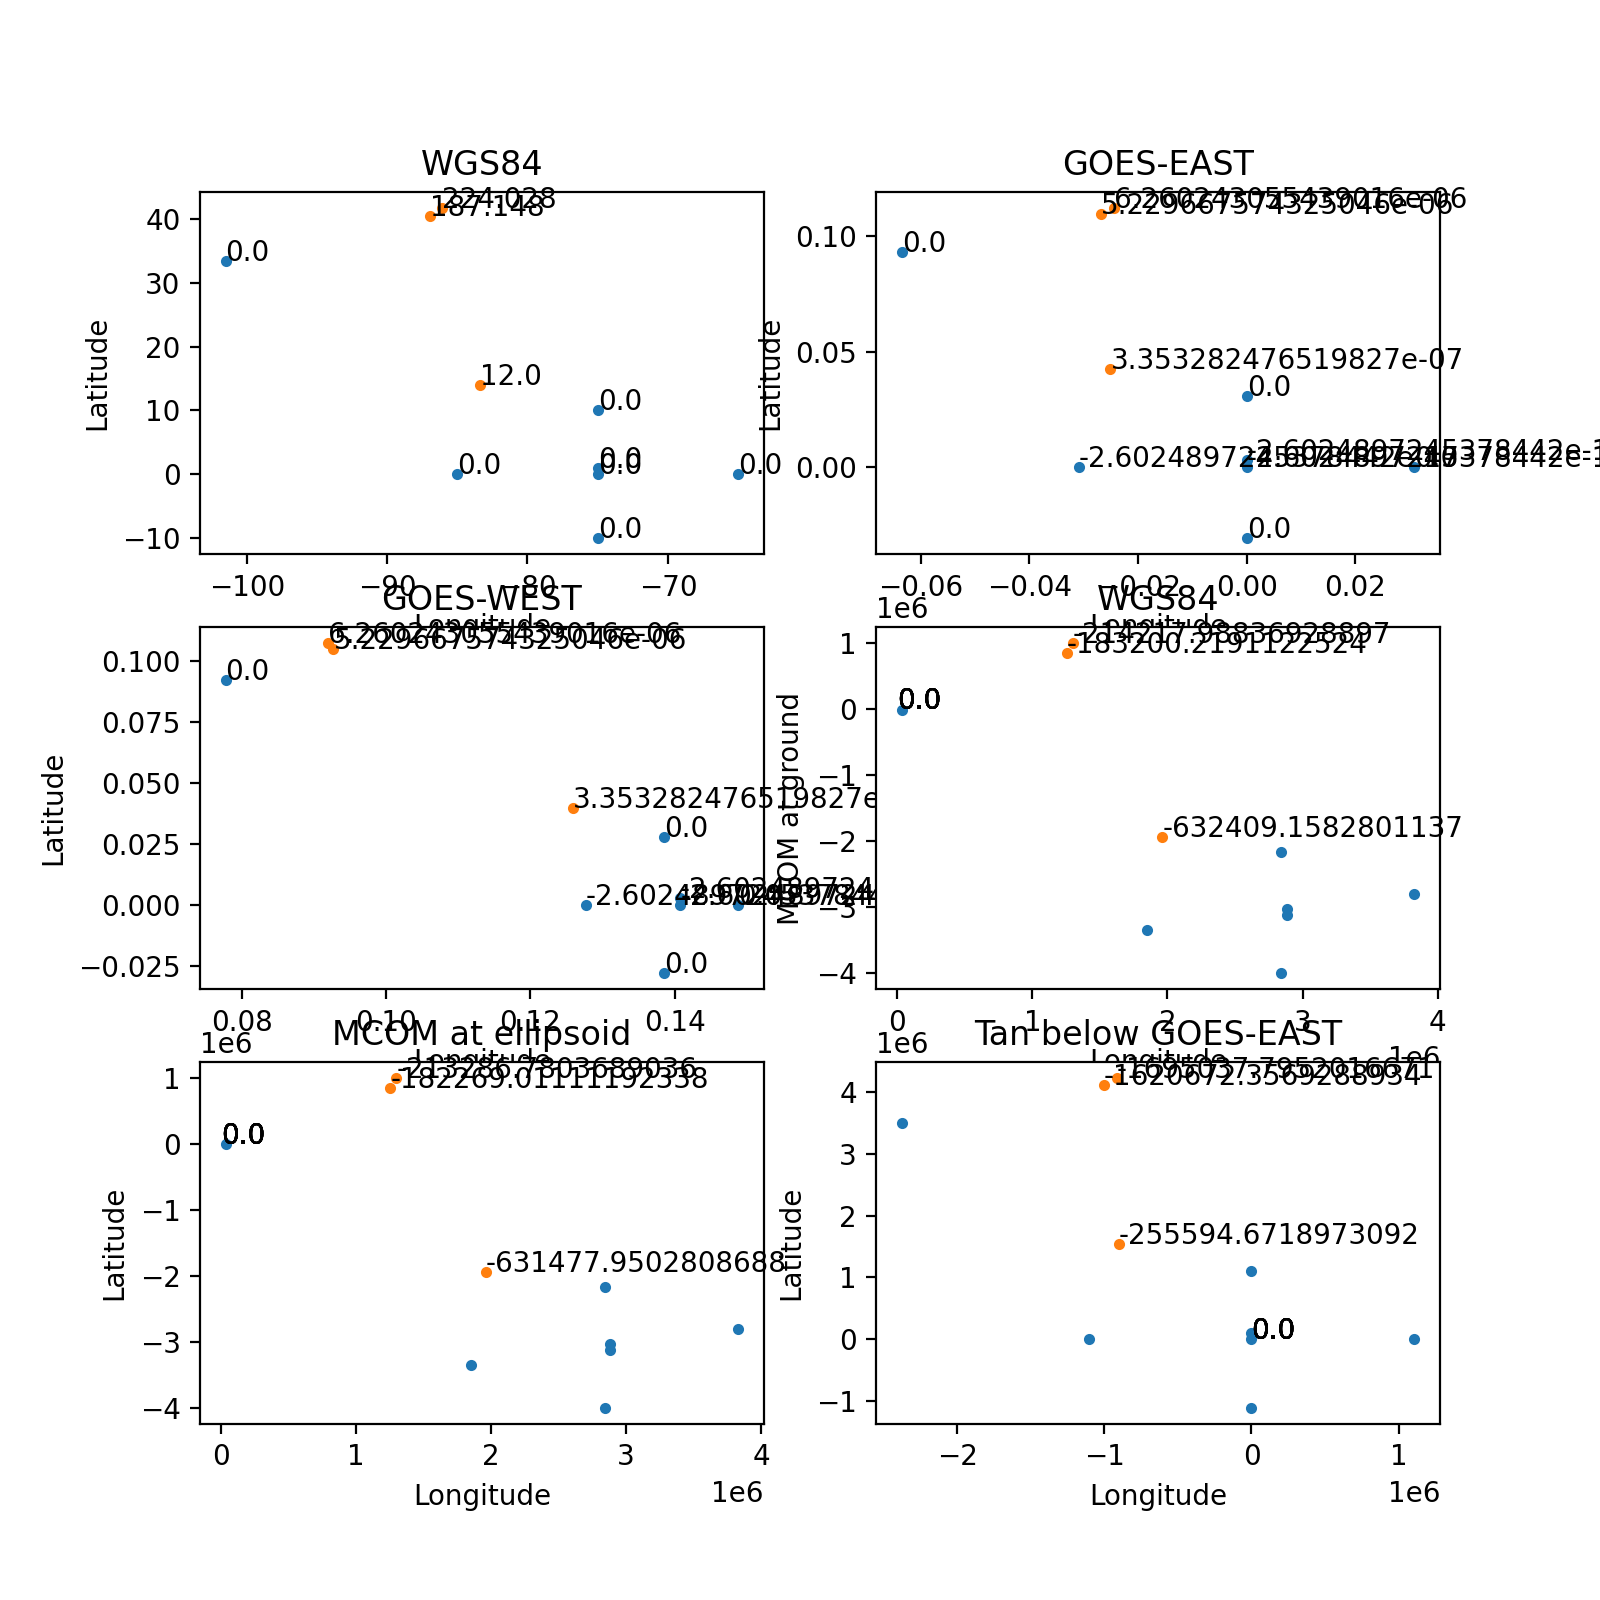

In [105]:
# identifying my three locations (Osceola, IN - Purdue - Puerto Cabezas, Nicaragua)
# putting the corresponding lats/lons in arrays
loc_lon = np.array([-86.0758, -86.9292, -83.3950])
loc_lat = np.array([41.6650, 40.4237, 14.0391])
loc_alt = np.array([224.028, 187.148, 12])

# transforming lat/lin arrays to ECEF
location_X, location_Y, location_Z = geo.toECEF(loc_lon, loc_lat, loc_alt)
print (location_X, location_Y, location_Z)

# I began to lack creativity in my varaibles. I apologize.
# transforming the three tangants and GOES E/W to ECEF
x1, y1, z1 = GOES_EAST_COORD.fromECEF(location_X, location_Y, location_Z)
x2, y2, z2 = GOES_WEST_COORD.fromECEF(location_X, location_Y, location_Z)
x3, y3, z3 = mcom1.fromECEF(location_X, location_Y, location_Z)
x4, y4, z4 = mcom2.fromECEF(location_X, location_Y, location_Z)
x5, y5, z5 = goes_east.fromECEF(location_X, location_Y, location_Z)

# below shows all my plotting code
%matplotlib notebook
import matplotlib.pyplot as plt
n_rows, n_cols = 3, 2
fig, axes = plt.subplots(n_rows, n_cols, figsize=(8,8))

axes[0,0].plot
axes[0,0].set_xlabel('Longitude')
axes[0,0].set_ylabel('Latitude')
axes[0,0].set_title('WGS84')
axes[0,0].plot(lon, lat, marker='.', linestyle='none')
axes[0,0].plot(loc_lon, loc_lat, marker='.', linestyle='none')

axes[0,1].plot
axes[0,1].set_xlabel('Longitude')
axes[0,1].set_ylabel('Latitude')
axes[0,1].set_title('GOES-EAST')
axes[0,1].plot(EAST_X, EAST_Y, marker='.', linestyle='none')
axes[0,1].plot(x1, y1, marker='.', linestyle='none')

axes[1,0].plot
axes[1,0].set_xlabel('Longitude')
axes[1,0].set_ylabel('Latitude')
axes[1,0].set_title('GOES-WEST')
axes[1,0].plot(WEST_X, WEST_Y, marker='.', linestyle='none')
axes[1,0].plot(x2, y2, marker='.', linestyle='none')

axes[1,1].plot
axes[1,1].set_xlabel('Longitude')
axes[1,1].set_ylabel('MCOM at ground')
axes[1,1].set_title('WGS84')
axes[1,1].plot(mcom1x, mcom1y, marker='.', linestyle='none')
axes[1,1].plot(x3, y3, marker='.', linestyle='none')

axes[2,0].plot
axes[2,0].set_xlabel('Longitude')
axes[2,0].set_ylabel('Latitude')
axes[2,0].set_title('MCOM at ellipsoid')
axes[2,0].plot(mcom2x, mcom2y, marker='.', linestyle='none')
axes[2,0].plot(x4, y4, marker='.', linestyle='none')

axes[2,1].plot
axes[2,1].set_xlabel('Longitude')
axes[2,1].set_ylabel('Latitude')
axes[2,1].set_title('Tan below GOES-EAST')
axes[2,1].plot(goes_eastx, goes_easty, marker='.', linestyle='none')
axes[2,1].plot(x5, y5, marker='.', linestyle='none')

# These labels seem like they should be simple
# but I am having trouble with them
# I am confused on what should be inserted and where
# I have commented them out for now
for tlon, tlat, tlabel in zip(lon, lat, alt):
    axes[0,0].text(tlon, tlat, tlabel)
for tlon, tlat, tlabel in zip(loc_lon, loc_lat, loc_alt):
    axes[0,0].text(tlon, tlat, tlabel)
    
#for tlon, tlat, tlabel in zip(EAST_X, EAST_Y, EAST_Z):
    #axes[0,1].text(tlon, tlat, tlabel)
#for tlon, tlat, tlabel in zip(x1, y1, z1):
    #axes[0,1].text(tlon, tlat, tlabel)
    
#for tlon, tlat, tlabel in zip(WEST_X, WEST_Y, WEST_Z):
    #axes[1,0].text(tlon, tlat, tlabel)
#for tlon, tlat, tlabel in zip(x2, y2, z2):
    #axes[1,0].text(tlon, tlat, tlabel)
    
#for tlon, tlat, tlabel in zip():
    #axes[1,1].text(tlon, tlat, tlabel)
#for tlon, tlat, tlabel in zip(x3, y3, z3):
    #axes[1,1].text(tlon, tlat, tlabel)
    
#for tlon, tlat, tlabel in zip():
    #axes[2,0].text(tlon, tlat, tlabel)
#for tlon, tlat, tlabel in zip(x4, y4, z4):
    #axes[2,0].text(tlon, tlat, tlabel)
    
#for tlon, tlat, tlabel in zip():
    #axes[2,1].text(tlon, tlat, tlabel)
#for tlon, tlat, tlabel in zip(x5, y5, z5):
    #axes[2,1].text(tlon, tlat, tlabel)
    
#fig.tight_layout()

Yes, I believe everything does make sense. I think?

**5.** Using the arrays you created in the previous assignment, create a `pcolormesh` plot of the data in geostationary coordinates from both the GOES East and GOES West positions. (15 pts.)

<IPython.core.display.Javascript object>


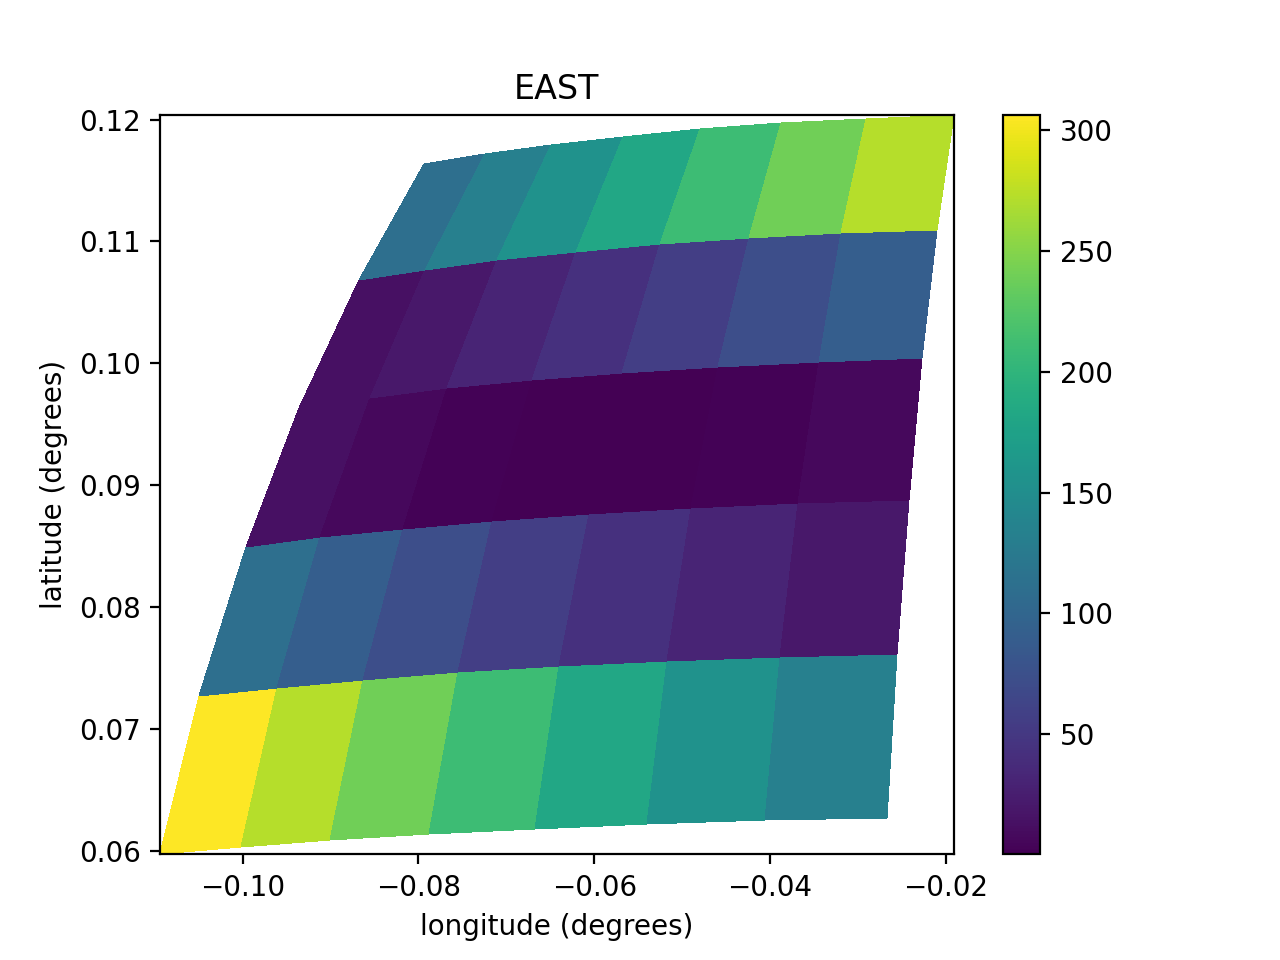

<IPython.core.display.Javascript object>


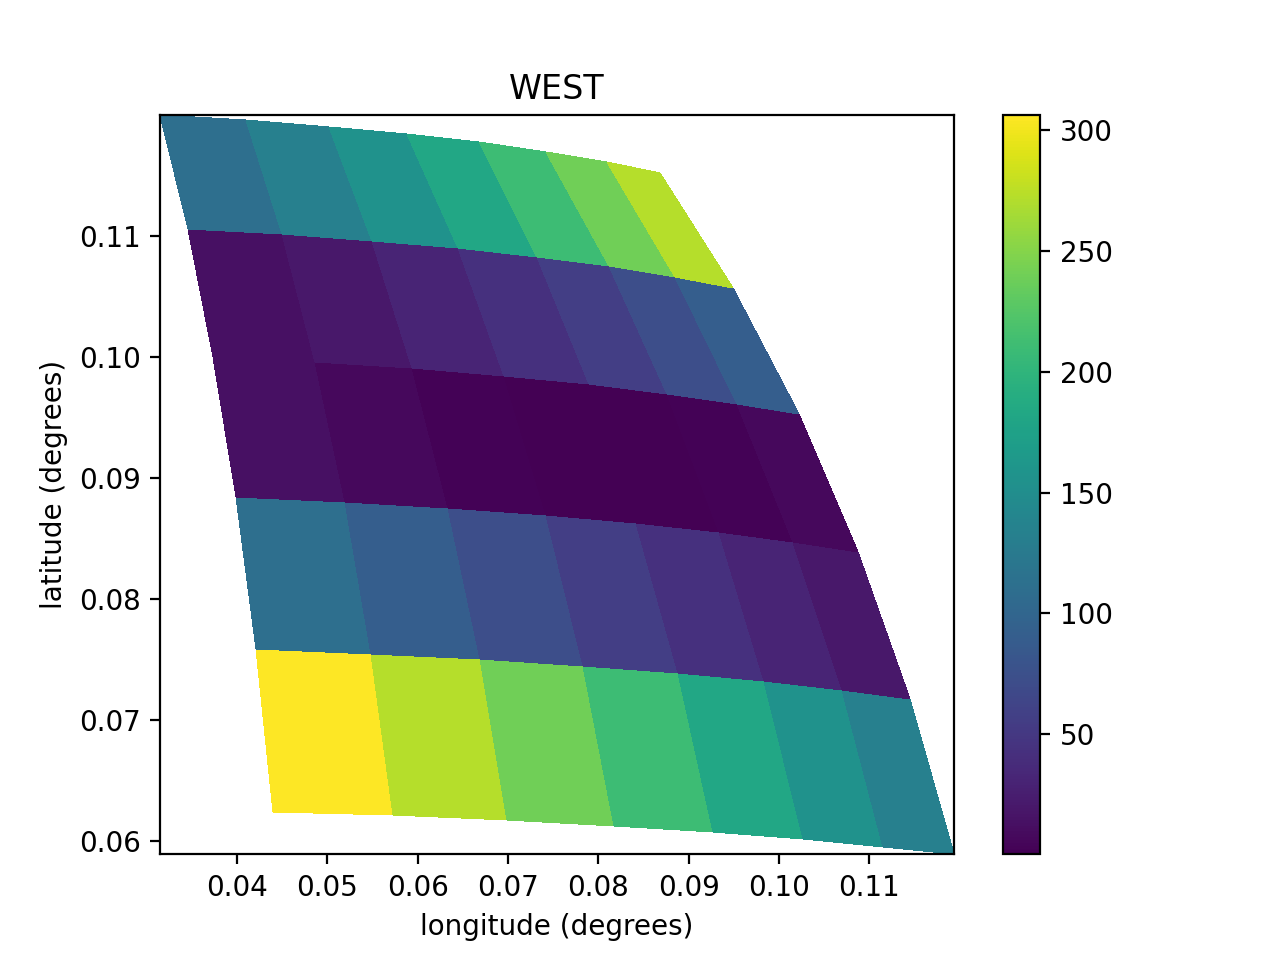

Text(0.5, 1.0, 'WEST')

In [111]:
# The following was generated using code from assignment 1 as an example

nlon = 7
nlat = 5
dlon, dlat = 5.0, 5.0

d = (np.arange(nlon*nlat) - (nlon*nlat/2.0))**2.0
d.shape = (nlat, nlon)

lon = np.array ([mcom_lon-3*dlon, mcom_lon-2*dlon, mcom_lon-dlon, mcom_lon, mcom_lon+dlon, mcom_lon+2*dlon, mcom_lon+3*dlon])
lat = np.array ([mcom_lat-2*dlat, mcom_lat-dlat, mcom_lat, mcom_lat+dlat, mcom_lat+2*dlat])

def centers_to_edges_1d(x):
    dx =  5/2
    value = np.arange(np.min(x)-dx, np.max(x)+dx+dx/2, 2*dx)
    return value
    
lon_edge = centers_to_edges_1d(lon)
lat_edge = centers_to_edges_1d(lat)
lon_edge_2d, lat_edge_2d = np.meshgrid(lon_edge, lat_edge)

ar = np.zeros_like(lon_edge_2d)

# coverting coordinates
x9, y9, z9 = geo.toECEF(lon_edge_2d, lat_edge_2d, ar)
x7, y7, z7 = GOES_EAST_COORD.fromECEF(x9, y9, z9)
x8, y8, z8 = GOES_WEST_COORD.fromECEF(x9, y9, z9)

#plotting figures
fig = plt.figure()
ax = fig.add_subplot(111)
im = ax.pcolormesh(x7, y7, d)
plt.colorbar(im)
ax.set_xlabel('longitude (degrees)')
ax.set_ylabel('latitude (degrees)')
ax.set_title('EAST')

fig = plt.figure()
ax = fig.add_subplot(111)
im = ax.pcolormesh(x8, y8, d)
plt.colorbar(im)
ax.set_xlabel('longitude (degrees)')
ax.set_ylabel('latitude (degrees)')
ax.set_title('WEST')

**6.** One thing we didn't do in the previous assignment was plot in a "traditional" map projection. We'll do that now with the Azimuthal Equidistant and Gnomonic projections, centered on MCOM, as defined below. The MapProjection class has the same to/from ECEF methods, and coordinates returned are in meters relative to the center point. (15 pts.)

If you're curious, you can peruse [the full list of projections](https://proj.org/operations/projections/index.html) to see how to define others.

Create a plot of the same data in each map projection, and set the axis limits to +/- 1600 km. Do you notice any differences in the two projections?

In [43]:
from coordinateSystems import MapProjection

aeqd = MapProjection(projection='aeqd', lon_0=mcom_lon, lat_0=mcom_lat)
gnom = MapProjection(projection='gnom', lon_0=mcom_lon, lat_0=mcom_lat)

<IPython.core.display.Javascript object>


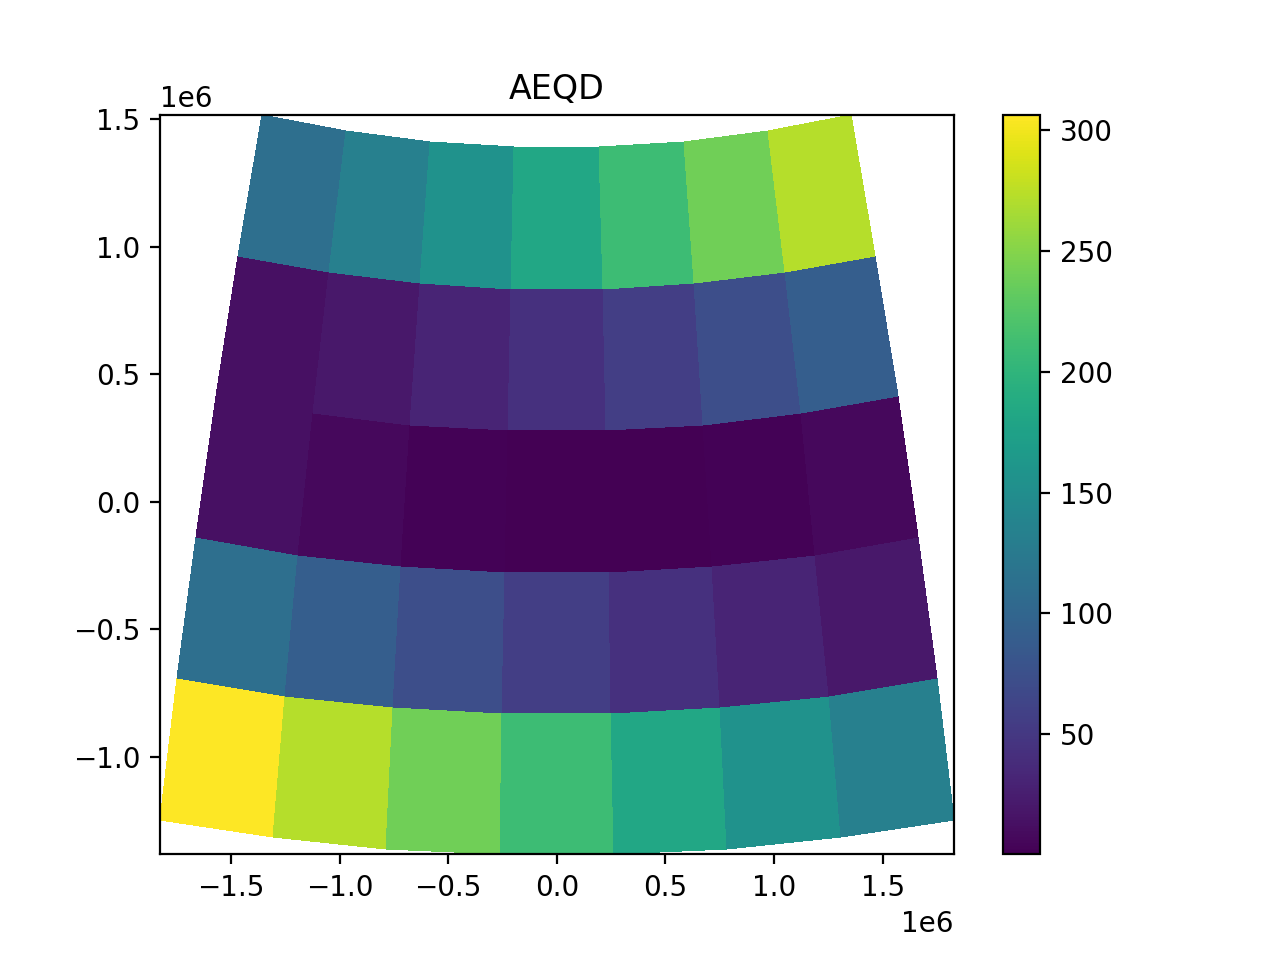

<IPython.core.display.Javascript object>


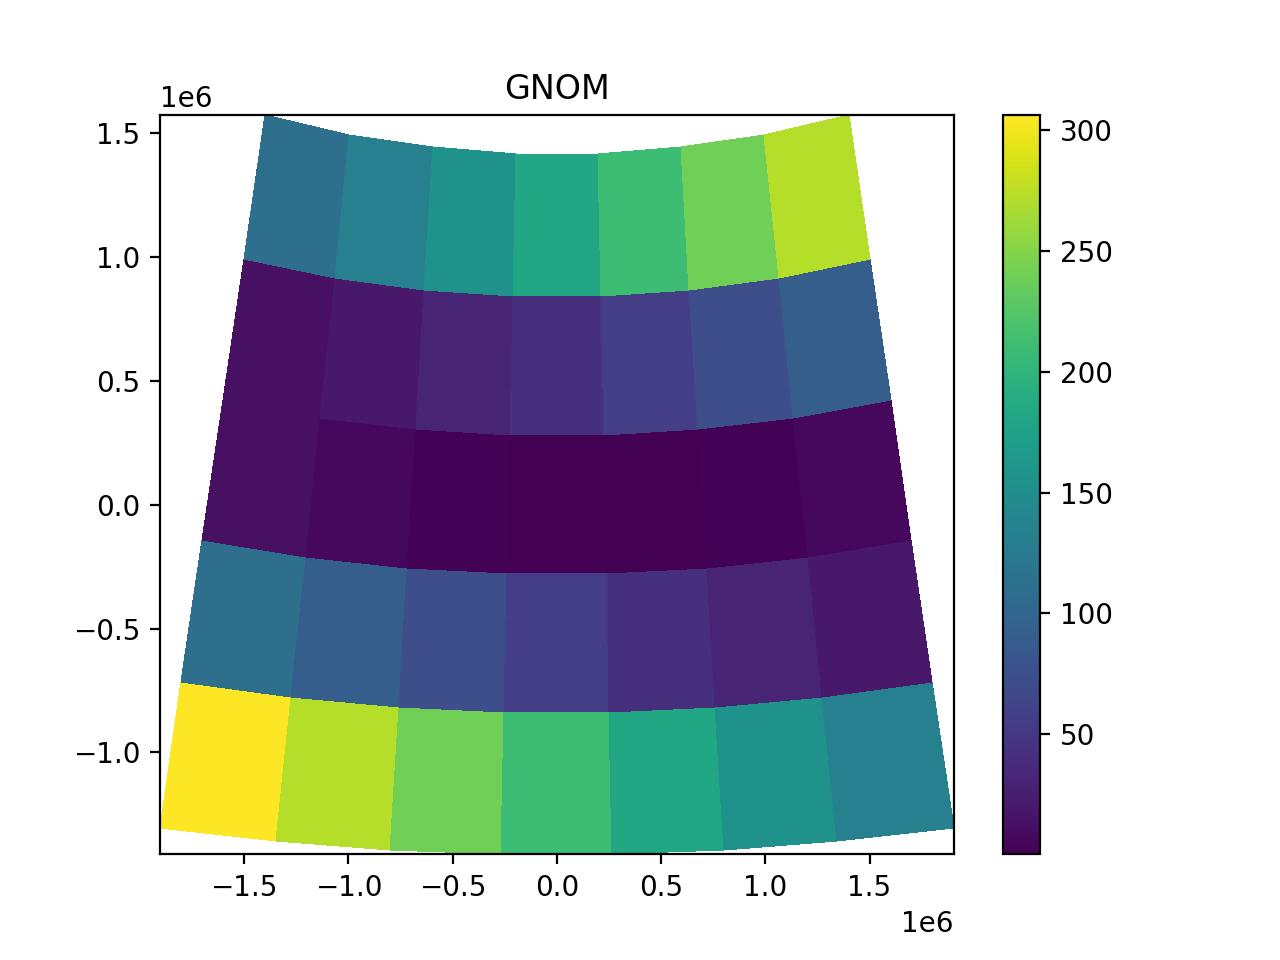

Text(0.5, 1.0, 'GNOM')

In [141]:
# coord conversions fro AEQD and GNOM
x7,y7,z7 = aeqd.fromECEF(t1, t2, t3)
x8,y8,z8 = gnom.fromECEF(t1, t2, t3)

# plotting figures
# based these on code from last assignment
fig = plt.figure()
ax = fig.add_subplot(111)
im = ax.pcolormesh(x7,y7,d)
plt.colorbar(im)
ax.set_title('AEQD')

fig = plt.figure()
ax = fig.add_subplot(111)
im = ax.pcolormesh(x8,y8,d)
plt.colorbar(im)
ax.set_title('GNOM')

In [ ]:
They look exactly the same, but Im assuming this is becuase I dontunderstand the 1600 limit aspect of the problem. 
I know how to set x and y axes, but when i set to +/-1600km, the plots look completely wrong.